In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
df = pd.read_csv("lung cancer.csv")

# Check for null values
print("Null values:\n", df.isnull().sum())

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", categorical_cols)

# Apply label encoding to categorical columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Verify the transformation
print("Data after encoding:\n", df.head())

# Handle missing values with forward fill
df.fillna(method='ffill', inplace=True)

# Splitting data into features and target variable
X = df.drop('LUNG_CANCER', axis=1)
y = df['LUNG_CANCER']
print("Features shape:", X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data for all models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Prepare data for CNN and MobileNet (reshape to 2D/3D input)
num_features = X_train.shape[1]
# For CNN, reshape to (samples, height, width, channels)
min_size = int(np.ceil(np.sqrt(num_features)))
pad_size = min_size * min_size - num_features
if pad_size > 0:
    X_train_padded = np.pad(X_train_scaled, ((0, 0), (0, pad_size)), mode='constant')
    X_test_padded = np.pad(X_test_scaled, ((0, 0), (0, pad_size)), mode='constant')
else:
    X_train_padded = X_train_scaled
    X_test_padded = X_test_scaled

# Reshape for CNN (e.g., min_size x min_size x 1)
X_train_cnn = X_train_padded.reshape(-1, min_size, min_size, 1)
X_test_cnn = X_test_padded.reshape(-1, min_size, min_size, 1)

# For MobileNet, resize to at least 32x32x3
mobilenet_size = 32
X_train_mobilenet = np.repeat(X_train_cnn, mobilenet_size // min_size + 1, axis=1)[:, :mobilenet_size, :, :]
X_train_mobilenet = np.repeat(X_train_mobilenet, mobilenet_size // min_size + 1, axis=2)[:, :, :mobilenet_size, :]
X_test_mobilenet = np.repeat(X_test_cnn, mobilenet_size // min_size + 1, axis=1)[:, :mobilenet_size, :, :]
X_test_mobilenet = np.repeat(X_test_mobilenet, mobilenet_size // min_size + 1, axis=2)[:, :, :mobilenet_size, :]
X_train_mobilenet = np.repeat(X_train_mobilenet, 3, axis=3)
X_test_mobilenet = np.repeat(X_test_mobilenet, 3, axis=3)

# Store best models and training times
best_models = {}
training_times = {}

### Logistic Regression ###
start_time = time.time()
log_reg = LogisticRegression(max_iter=500)
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_reg_cv = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='accuracy')
log_reg_cv.fit(X_train_scaled, y_train)
best_models['Logistic Regression'] = log_reg_cv.best_estimator_
training_times['Logistic Regression'] = time.time() - start_time

### Decision Tree ###
start_time = time.time()
dt = DecisionTreeClassifier()
dt_params = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}
dt_cv = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy')
dt_cv.fit(X_train_scaled, y_train)
best_models['Decision Tree'] = dt_cv.best_estimator_
training_times['Decision Tree'] = time.time() - start_time

### Random Forest ###
start_time = time.time()
rf = RandomForestClassifier()
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}
rf_cv = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy')
rf_cv.fit(X_train_scaled, y_train)
best_models['Random Forest'] = rf_cv.best_estimator_
training_times['Random Forest'] = time.time() - start_time

### ElasticNet ###
start_time = time.time()
elastic_net = ElasticNet()
elastic_params = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}
elastic_cv = GridSearchCV(elastic_net, elastic_params, cv=5, scoring='r2')
elastic_cv.fit(X_train_scaled, y_train)
best_models['ElasticNet Regression'] = elastic_cv.best_estimator_
training_times['ElasticNet Regression'] = time.time() - start_time

### Gradient Boosting ###
start_time = time.time()
gb = GradientBoostingClassifier()
gb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]}
gb_cv = GridSearchCV(gb, gb_params, cv=5, scoring='accuracy')
gb_cv.fit(X_train_scaled, y_train)
best_models['Gradient Boosting'] = gb_cv.best_estimator_
training_times['Gradient Boosting'] = time.time() - start_time

### XGBoost ###
start_time = time.time()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]}
xgb_cv = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy')
xgb_cv.fit(X_train_scaled, y_train)
best_models['XGBoost'] = xgb_cv.best_estimator_
training_times['XGBoost'] = time.time() - start_time

### Gaussian Naïve Bayes ###
start_time = time.time()
gnb = GaussianNB()
gnb_params = {'var_smoothing': np.logspace(-9, 0, 10)}
gnb_cv = GridSearchCV(gnb, gnb_params, cv=5, scoring='accuracy')
gnb_cv.fit(X_train_scaled, y_train)
best_models['GaussianNB'] = gnb_cv.best_estimator_
training_times['GaussianNB'] = time.time() - start_time

### Support Vector Machine (SVM) ###
start_time = time.time()
svm = SVC(probability=True)
svm_params = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'gamma': ['scale', 'auto']}
svm_cv = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy')
svm_cv.fit(X_train_scaled, y_train)
best_models['SVM'] = svm_cv.best_estimator_
training_times['SVM'] = time.time() - start_time

### CNN ###
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

start_time = time.time()
cnn_model = create_cnn_model((min_size, min_size, 1))
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
best_models['CNN'] = cnn_model
training_times['CNN'] = time.time() - start_time

### MobileNet ###
def create_mobilenet_model(input_shape):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

start_time = time.time()
mobilenet_model = create_mobilenet_model((mobilenet_size, mobilenet_size, 3))
mobilenet_model.fit(X_train_mobilenet, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
best_models['MobileNet'] = mobilenet_model
training_times['MobileNet'] = time.time() - start_time

# Evaluate Best Models and Collect Metrics
model_results = {}
model_names = []
accuracies = []
roc_auc_scores = []

for model_name, model in best_models.items():
    # Predict probabilities
    if model_name in ['CNN', 'MobileNet']:
        y_prob = model.predict(X_test_cnn if model_name == 'CNN' else X_test_mobilenet, verbose=0).flatten()
        y_pred = (y_prob >= 0.5).astype(int)
    else:
        if model_name == 'ElasticNet Regression':
            # For ElasticNet, predict continuous values and threshold at 0.5
            y_prob = model.predict(X_test_scaled)
            y_pred = (y_prob >= 0.5).astype(int)
        else:
            y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_test_scaled)
            y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0) if model_name != 'ElasticNet Regression' else np.nan
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0) if model_name != 'ElasticNet Regression' else np.nan
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0) if model_name != 'ElasticNet Regression' else np.nan
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Specificity calculation
    TN, FP, FN, TP = conf_matrix.ravel()
    specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan

    # Classification report
    class_report = classification_report(y_test, y_pred, target_names=['Non-Cancer', 'Cancer'], zero_division=0) if model_name != 'ElasticNet Regression' else 'N/A'

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob) if model_name != 'ElasticNet Regression' else (np.nan, np.nan, np.nan)
    roc_auc = auc(fpr, tpr) if model_name != 'ElasticNet Regression' else np.nan

    # Store results
    model_results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'Confusion Matrix': conf_matrix,
        'Classification Report': class_report,
        'ROC AUC': roc_auc,
        'FPR': fpr,
        'TPR': tpr
    }

    # Append data for comparison
    model_names.append(model_name)
    accuracies.append(accuracy)
    roc_auc_scores.append(roc_auc if not np.isnan(roc_auc) else 0)

# Print Training Times
print("\n🔹 Training Times 🔹")
for model_name, train_time in training_times.items():
    print(f"{model_name}: {train_time:.2f} seconds")
fastest_model = min(training_times, key=training_times.get)
print(f"\nFastest Model: {fastest_model} ({training_times[fastest_model]:.2f} seconds)\n")

# Print Model Evaluation Results
for model, metrics in model_results.items():
    print(f"\n🔹 {model} Evaluation 🔹")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f if not np.isnan(metrics['Precision']) else 'N/A'}")
    print(f"Recall (Sensitivity): {metrics['Recall']:.4f if not np.isnan(metrics['Recall']) else 'N/A'}")
    print(f"Specificity: {metrics['Specificity']:.4f if not np.isnan(metrics['Specificity']) else 'N/A'}")
    print(f"F1-Score: {metrics['F1-Score']:.4f if not np.isnan(metrics['F1-Score']) else 'N/A'}")
    print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}")
    print(f"Classification Report:\n{metrics['Classification Report']}")
    print("-" * 50)

# Create Summary Table
summary_data = {
    'Model': [],
    'Accuracy': [],
    'Sensitivity (Recall)': [],
    'Specificity': [],
    'Precision': [],
    'F1-Score': [],
    'Training Time (s)': []
}

for model_name in model_results:
    metrics = model_results[model_name]
    summary_data['Model'].append(model_name)
    summary_data['Accuracy'].append(metrics['Accuracy'])
    summary_data['Sensitivity (Recall)'].append(metrics['Recall'])
    summary_data['Specificity'].append(metrics['Specificity'])
    summary_data['Precision'].append(metrics['Precision'])
    summary_data['F1-Score'].append(metrics['F1-Score'])
    summary_data['Training Time (s)'].append(training_times[model_name])

summary_df = pd.DataFrame(summary_data)

# Format the DataFrame for display
summary_df['Accuracy'] = summary_df['Accuracy'].round(4)
summary_df['Sensitivity (Recall)'] = summary_df['Sensitivity (Recall)'].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else 'N/A')
summary_df['Specificity'] = summary_df['Specificity'].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else 'N/A')
summary_df['Precision'] = summary_df['Precision'].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else 'N/A')
summary_df['F1-Score'] = summary_df['F1-Score'].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else 'N/A')
summary_df['Training Time (s)'] = summary_df['Training Time (s)'].round(2)

# Print Summary Table
print("\n🔹 Final Summary Table 🔹")
print(summary_df.to_string(index=False))

# Plot Accuracy Comparison
plt.figure(figsize=(12, 6))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot ROC Curves for All Models
plt.figure(figsize=(10, 6))
for model_name, metrics in model_results.items():
    if model_name != 'ElasticNet Regression' and not np.isnan(metrics['ROC AUC']):
        plt.plot(metrics['FPR'], metrics['TPR'], lw=2, label=f'{model_name} (AUC = {metrics["ROC AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

Null values:
 GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64
Categorical Columns: Index(['GENDER', 'LUNG_CANCER'], dtype='object')
Data after encoding:
    GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0       1   69        1               2        2              1   
1       1   74        2               1        1              1   
2       0   59        1               1        1              2   
3       1   63        2               2        2              1   
4       0   63        1               2        1              1   

   CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZI

<ipython-input-12-f73492816e95>:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:21:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:21:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:21:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:21:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label


🔹 Training Times 🔹
Logistic Regression: 0.26 seconds
Decision Tree: 0.38 seconds
Random Forest: 15.35 seconds
ElasticNet Regression: 0.28 seconds
Gradient Boosting: 90.39 seconds
XGBoost: 27.11 seconds
GaussianNB: 0.22 seconds
SVM: 523.97 seconds
CNN: 9.02 seconds
MobileNet: 70.74 seconds

Fastest Model: GaussianNB (0.22 seconds)


🔹 Logistic Regression Evaluation 🔹
Accuracy: 0.9404


ValueError: Invalid format specifier '.4f if not np.isnan(metrics['Precision']) else 'N/A'' for object of type 'float'

Null values:
 GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64
Categorical Columns: Index(['GENDER', 'LUNG_CANCER'], dtype='object')
Data after encoding:
    GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0       1   69        1               2        2              1   
1       1   74        2               1        1              1   
2       0   59        1               1        1              2   
3       1   63        2               2        2              1   
4       0   63        1               2        1              1   

   CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZI

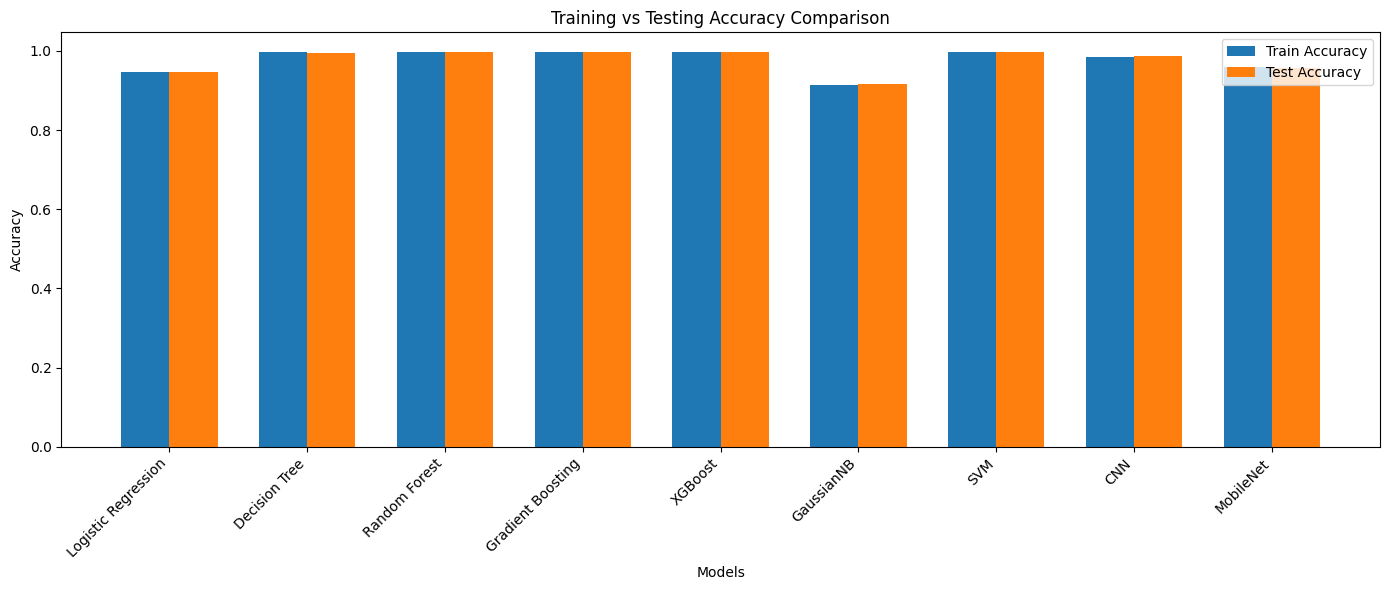

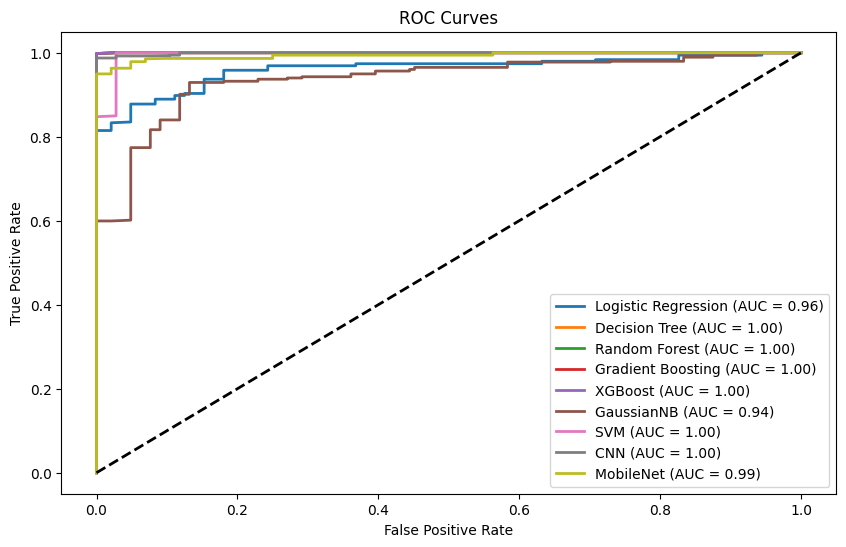

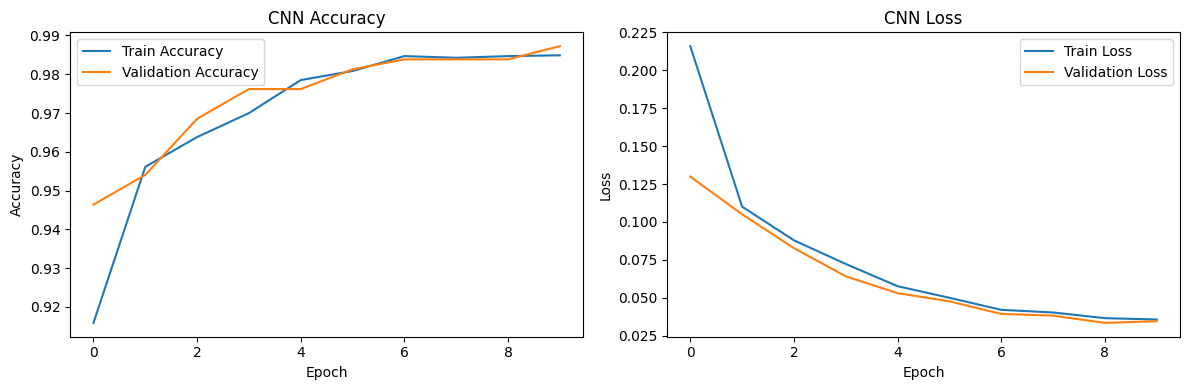

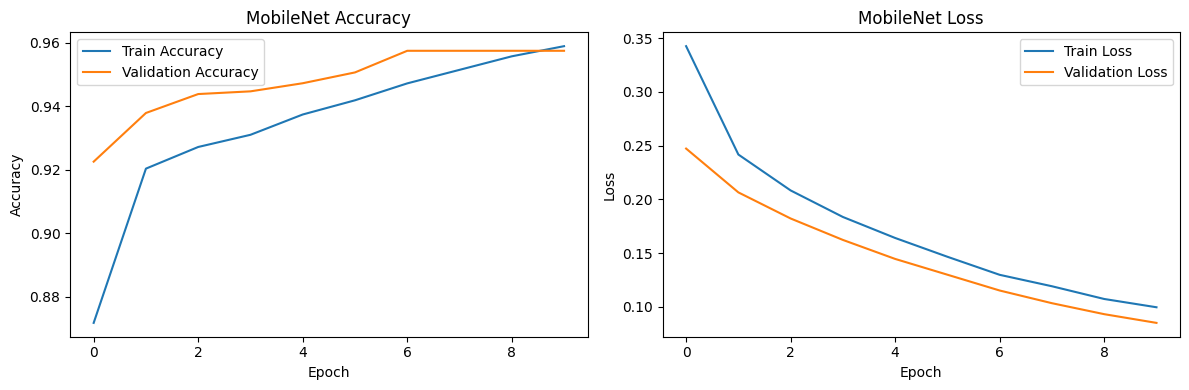

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
df = pd.read_csv("lung cancer.csv")

# Check for null values
print("Null values:\n", df.isnull().sum())

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", categorical_cols)

# Apply label encoding to categorical columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Verify the transformation
print("Data after encoding:\n", df.head())

# Handle missing values with forward fill
df.fillna(method='ffill', inplace=True)

# Splitting data into features and target variable
X = df.drop('LUNG_CANCER', axis=1)
y = df['LUNG_CANCER']
print("Features shape:", X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data for all models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Prepare data for CNN and MobileNet (reshape to 2D/3D input)
num_features = X_train.shape[1]
min_size = int(np.ceil(np.sqrt(num_features)))
pad_size = min_size * min_size - num_features
if pad_size > 0:
    X_train_padded = np.pad(X_train_scaled, ((0, 0), (0, pad_size)), mode='constant')
    X_test_padded = np.pad(X_test_scaled, ((0, 0), (0, pad_size)), mode='constant')
else:
    X_train_padded = X_train_scaled
    X_test_padded = X_test_scaled

# Reshape for CNN
X_train_cnn = X_train_padded.reshape(-1, min_size, min_size, 1)
X_test_cnn = X_test_padded.reshape(-1, min_size, min_size, 1)

# For MobileNet, resize to at least 32x32x3
mobilenet_size = 32
X_train_mobilenet = np.repeat(X_train_cnn, mobilenet_size // min_size + 1, axis=1)[:, :mobilenet_size, :, :]
X_train_mobilenet = np.repeat(X_train_mobilenet, mobilenet_size // min_size + 1, axis=2)[:, :, :mobilenet_size, :]
X_test_mobilenet = np.repeat(X_test_cnn, mobilenet_size // min_size + 1, axis=1)[:, :mobilenet_size, :, :]
X_test_mobilenet = np.repeat(X_test_mobilenet, mobilenet_size // min_size + 1, axis=2)[:, :, :mobilenet_size, :]
X_train_mobilenet = np.repeat(X_train_mobilenet, 3, axis=3)
X_test_mobilenet = np.repeat(X_test_mobilenet, 3, axis=3)

# Store models and metrics
best_models = {}
training_times = {}
train_accuracies = {}
test_accuracies = {}
history = {}  # For storing training history of neural networks

### Logistic Regression ###
start_time = time.time()
log_reg = LogisticRegression(max_iter=500)
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_reg_cv = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='accuracy', return_train_score=True)
log_reg_cv.fit(X_train_scaled, y_train)
best_models['Logistic Regression'] = log_reg_cv.best_estimator_
training_times['Logistic Regression'] = time.time() - start_time
train_accuracies['Logistic Regression'] = log_reg_cv.cv_results_['mean_train_score'][log_reg_cv.best_index_]
test_accuracies['Logistic Regression'] = log_reg_cv.best_score_

### Decision Tree ###
start_time = time.time()
dt = DecisionTreeClassifier()
dt_params = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}
dt_cv = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy', return_train_score=True)
dt_cv.fit(X_train_scaled, y_train)
best_models['Decision Tree'] = dt_cv.best_estimator_
training_times['Decision Tree'] = time.time() - start_time
train_accuracies['Decision Tree'] = dt_cv.cv_results_['mean_train_score'][dt_cv.best_index_]
test_accuracies['Decision Tree'] = dt_cv.best_score_

### Random Forest ###
start_time = time.time()
rf = RandomForestClassifier()
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}
rf_cv = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', return_train_score=True)
rf_cv.fit(X_train_scaled, y_train)
best_models['Random Forest'] = rf_cv.best_estimator_
training_times['Random Forest'] = time.time() - start_time
train_accuracies['Random Forest'] = rf_cv.cv_results_['mean_train_score'][rf_cv.best_index_]
test_accuracies['Random Forest'] = rf_cv.best_score_

### Gradient Boosting ###
start_time = time.time()
gb = GradientBoostingClassifier()
gb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]}
gb_cv = GridSearchCV(gb, gb_params, cv=5, scoring='accuracy', return_train_score=True)
gb_cv.fit(X_train_scaled, y_train)
best_models['Gradient Boosting'] = gb_cv.best_estimator_
training_times['Gradient Boosting'] = time.time() - start_time
train_accuracies['Gradient Boosting'] = gb_cv.cv_results_['mean_train_score'][gb_cv.best_index_]
test_accuracies['Gradient Boosting'] = gb_cv.best_score_

### XGBoost ###
start_time = time.time()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]}
xgb_cv = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy', return_train_score=True)
xgb_cv.fit(X_train_scaled, y_train)
best_models['XGBoost'] = xgb_cv.best_estimator_
training_times['XGBoost'] = time.time() - start_time
train_accuracies['XGBoost'] = xgb_cv.cv_results_['mean_train_score'][xgb_cv.best_index_]
test_accuracies['XGBoost'] = xgb_cv.best_score_

### Gaussian Naïve Bayes ###
start_time = time.time()
gnb = GaussianNB()
gnb_params = {'var_smoothing': np.logspace(-9, 0, 10)}
gnb_cv = GridSearchCV(gnb, gnb_params, cv=5, scoring='accuracy', return_train_score=True)
gnb_cv.fit(X_train_scaled, y_train)
best_models['GaussianNB'] = gnb_cv.best_estimator_
training_times['GaussianNB'] = time.time() - start_time
train_accuracies['GaussianNB'] = gnb_cv.cv_results_['mean_train_score'][gnb_cv.best_index_]
test_accuracies['GaussianNB'] = gnb_cv.best_score_

### Support Vector Machine (SVM) ###
start_time = time.time()
svm = SVC(probability=True)
svm_params = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'gamma': ['scale', 'auto']}
svm_cv = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', return_train_score=True)
svm_cv.fit(X_train_scaled, y_train)
best_models['SVM'] = svm_cv.best_estimator_
training_times['SVM'] = time.time() - start_time
train_accuracies['SVM'] = svm_cv.cv_results_['mean_train_score'][svm_cv.best_index_]
test_accuracies['SVM'] = svm_cv.best_score_

### CNN ###
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

start_time = time.time()
cnn_model = create_cnn_model((min_size, min_size, 1))
history['CNN'] = cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32,
                              validation_data=(X_test_cnn, y_test), verbose=0)
best_models['CNN'] = cnn_model
training_times['CNN'] = time.time() - start_time
train_accuracies['CNN'] = history['CNN'].history['accuracy'][-1]
test_accuracies['CNN'] = history['CNN'].history['val_accuracy'][-1]

### MobileNet ###
def create_mobilenet_model(input_shape):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

start_time = time.time()
mobilenet_model = create_mobilenet_model((mobilenet_size, mobilenet_size, 3))
history['MobileNet'] = mobilenet_model.fit(X_train_mobilenet, y_train, epochs=10, batch_size=32,
                                         validation_data=(X_test_mobilenet, y_test), verbose=0)
best_models['MobileNet'] = mobilenet_model
training_times['MobileNet'] = time.time() - start_time
train_accuracies['MobileNet'] = history['MobileNet'].history['accuracy'][-1]
test_accuracies['MobileNet'] = history['MobileNet'].history['val_accuracy'][-1]

# Evaluate models and collect metrics
model_results = {}
model_names = list(best_models.keys())

for model_name, model in best_models.items():
    if model_name in ['CNN', 'MobileNet']:
        y_prob = model.predict(X_test_cnn if model_name == 'CNN' else X_test_mobilenet, verbose=0).flatten()
        y_pred = (y_prob >= 0.5).astype(int)
    else:
        y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_test_scaled)
        y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    TN, FP, FN, TP = conf_matrix.ravel()
    specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    model_results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'Confusion Matrix': conf_matrix,
        'ROC AUC': roc_auc,
        'FPR': fpr,
        'TPR': tpr
    }

# Print training times
print("\n🔹 Training Times 🔹")
for model_name, train_time in training_times.items():
    print(f"{model_name}: {train_time:.2f} seconds")

# Print evaluation results
for model, metrics in model_results.items():
    print(f"\n🔹 {model} Evaluation 🔹")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall (Sensitivity): {metrics['Recall']:.4f}")
    print(f"Specificity: {metrics['Specificity']:.4f}")
    print(f"F1-Score: {metrics['F1-Score']:.4f}")
    print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}")
    print("-" * 50)

# Create summary table
summary_data = {
    'Model': model_names,
    'Train Accuracy': [train_accuracies[m] for m in model_names],
    'Test Accuracy': [test_accuracies[m] for m in model_names],
    'Precision': [model_results[m]['Precision'] for m in model_names],
    'Recall': [model_results[m]['Recall'] for m in model_names],
    'F1-Score': [model_results[m]['F1-Score'] for m in model_names],
    'Training Time (s)': [training_times[m] for m in model_names]
}

summary_df = pd.DataFrame(summary_data)
print("\n🔹 Final Summary Table 🔹")
print(summary_df.to_string(index=False))

# Plot training vs testing accuracy
plt.figure(figsize=(14, 6))
x = np.arange(len(model_names))
width = 0.35
plt.bar(x - width/2, [train_accuracies[m] for m in model_names], width, label='Train Accuracy')
plt.bar(x + width/2, [test_accuracies[m] for m in model_names], width, label='Test Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy Comparison')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
for model_name, metrics in model_results.items():
    plt.plot(metrics['FPR'], metrics['TPR'], lw=2, label=f'{model_name} (AUC = {metrics["ROC AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

# Plot training history for neural networks
for model_name in ['CNN', 'MobileNet']:
    if model_name in history:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history[model_name].history['accuracy'], label='Train Accuracy')
        plt.plot(history[model_name].history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history[model_name].history['loss'], label='Train Loss')
        plt.plot(history[model_name].history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

Dataset loaded successfully!

Data shape: (5871, 16)

First 5 rows:
  GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0      M   69        1               2        2              1   
1      M   74        2               1        1              1   
2      F   59        1               1        1              2   
3      M   63        2               2        2              1   
4      F   63        1               2        1              1   

   CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZING  ALCOHOL CONSUMING  COUGHING  \
0                1         2         1         2                  2         2   
1                2         2         2         1                  1         1   
2                1         2         1         2                  1         2   
3                1         1         1         1                  2         1   
4                1         1         1         2                  1         2   

   SHORTNESS OF BREATH  SWALLOWING DIFFICULTY  C

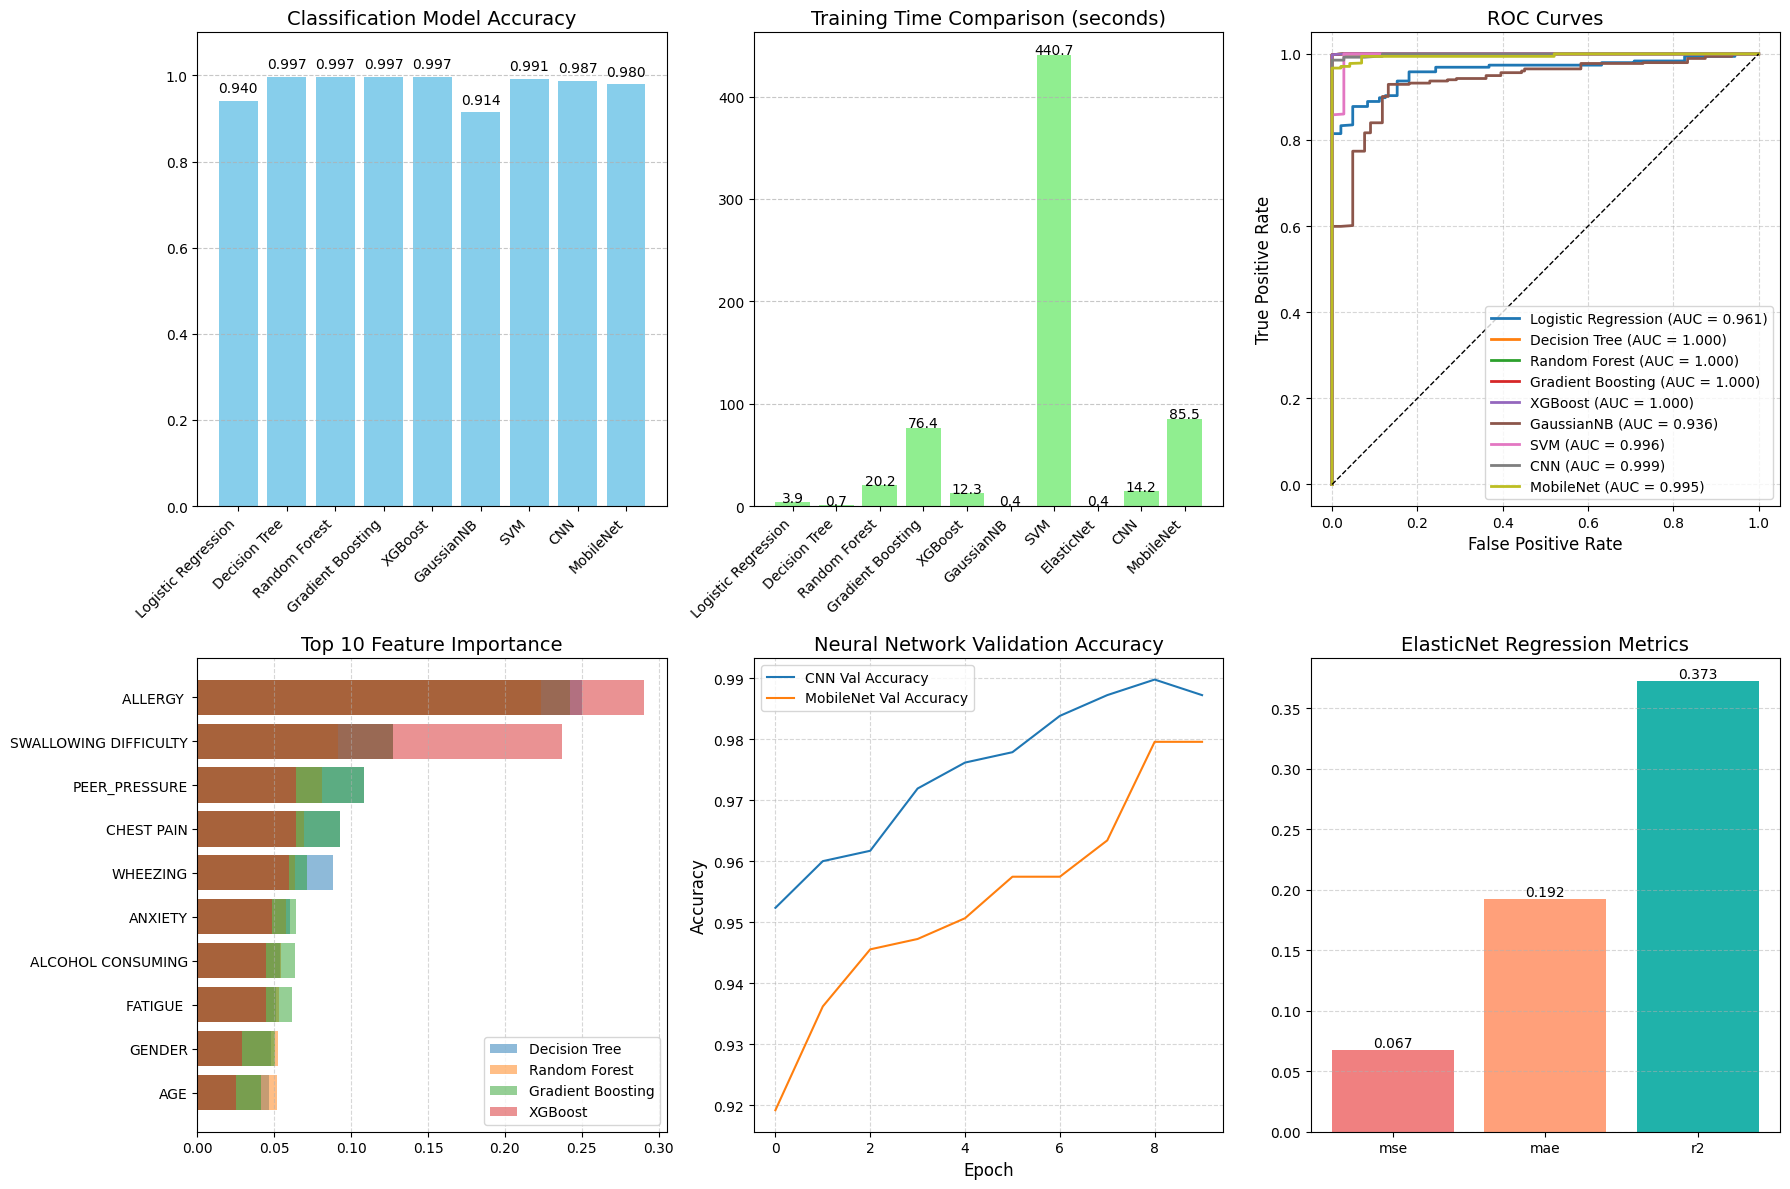

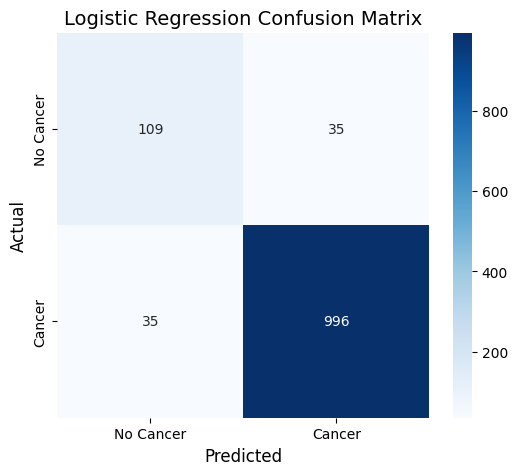

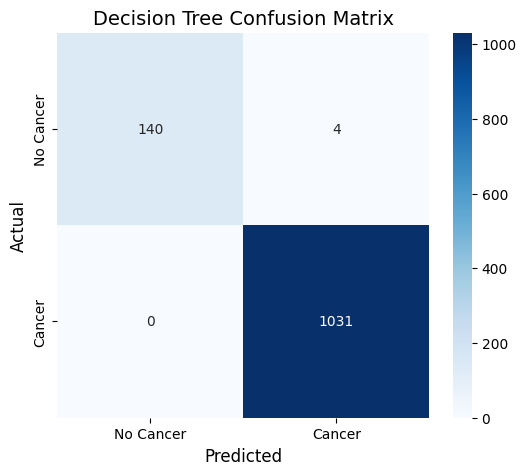

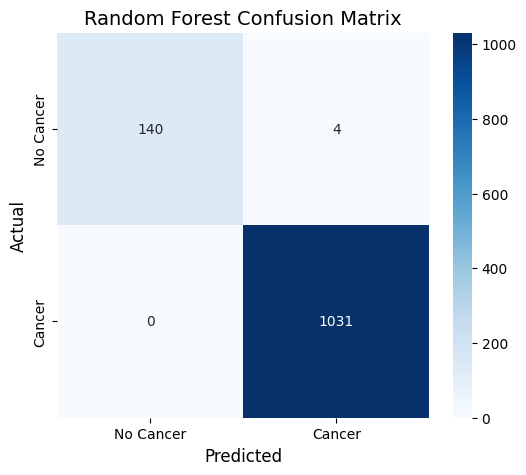

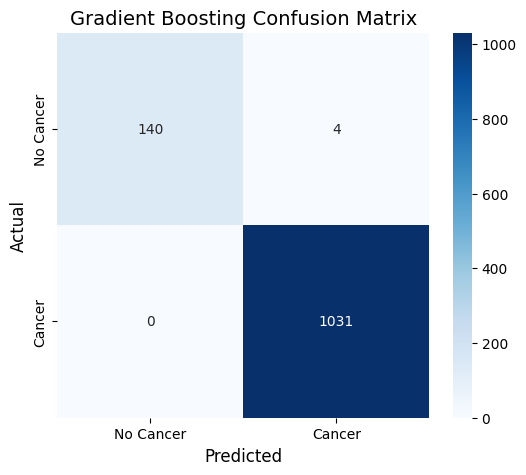

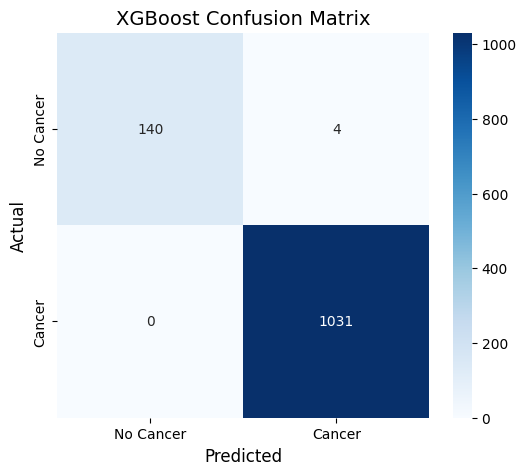

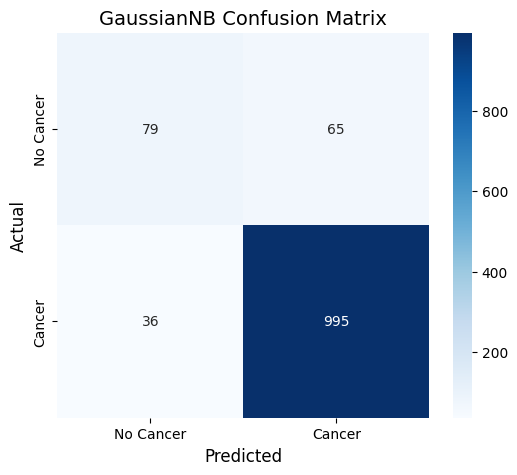

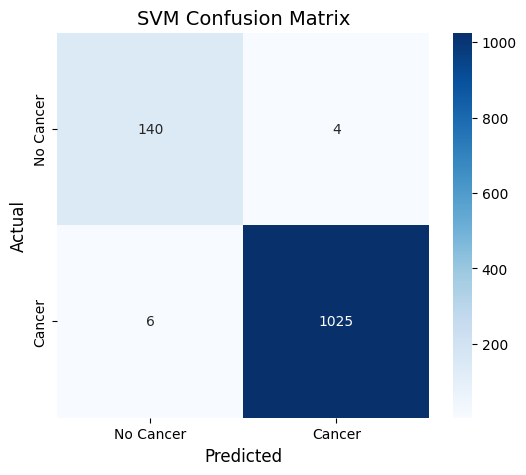

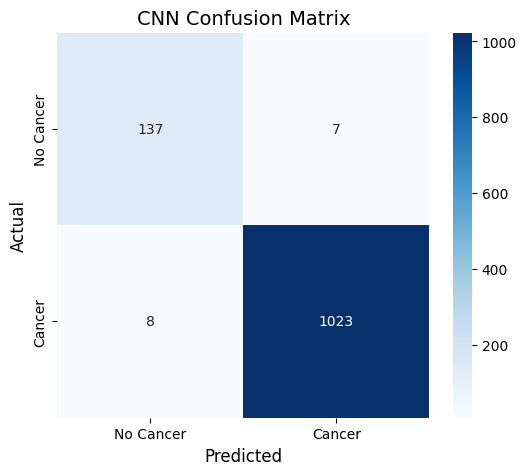

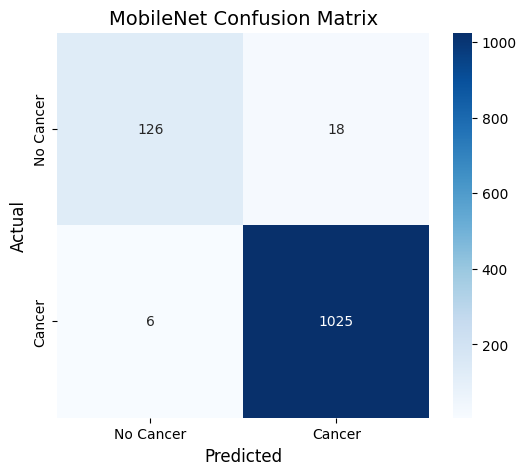

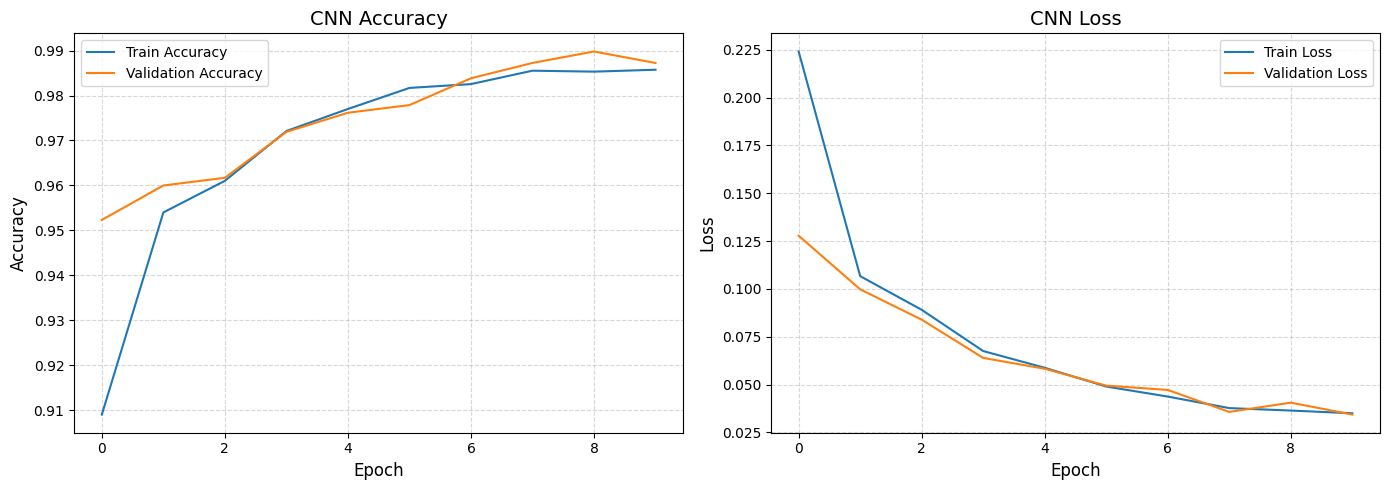

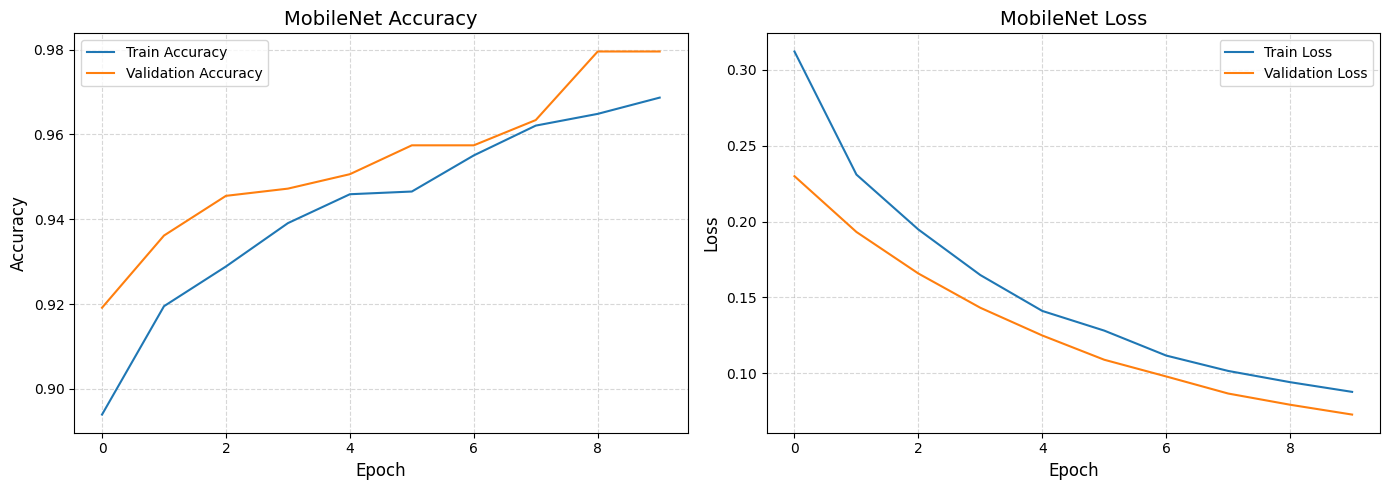

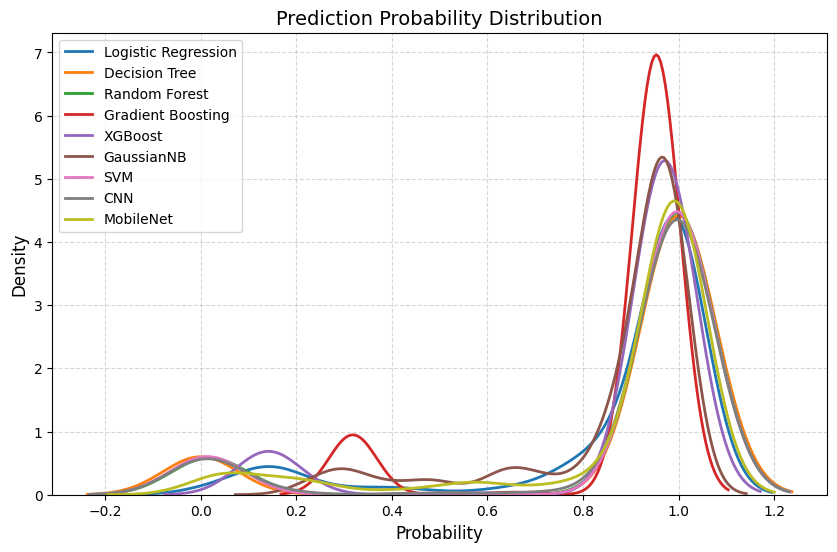


🔹 FINAL RESULTS SUMMARY 🔹

Comprehensive Metrics:
              Model           Type Train Score Test Score Precision Recall     F1 Time (s)                                            Key Params    AUC Specificity    MSE    MAE     R2
Logistic Regression Classification      0.9469     0.9463    0.9661 0.9661 0.9661     3.90                                         {'C': 100}... 0.9608      0.7569    NaN    NaN    NaN
      Decision Tree Classification      0.9969     0.9957    0.9961 1.0000 0.9981     0.69          {'max_depth': 10, 'min_samples_split': 2}... 1.0000      0.9722    NaN    NaN    NaN
      Random Forest Classification      0.9969     0.9962    0.9961 1.0000 0.9981    20.17             {'max_depth': 10, 'n_estimators': 100}... 1.0000      0.9722    NaN    NaN    NaN
  Gradient Boosting Classification      0.9968     0.9968    0.9961 1.0000 0.9981    76.35 {'learning_rate': 0.01, 'max_depth': 10, 'n_estima... 1.0000      0.9722    NaN    NaN    NaN
            XGBoost Clas

In [18]:
# ==============================================
# COMPLETE LUNG CANCER PREDICTION PIPELINE
# ==============================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_curve, auc,
                           mean_squared_error, r2_score, mean_absolute_error)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ==============================================
# DATA LOADING AND PREPROCESSING
# ==============================================

# Load the dataset
try:
    df = pd.read_csv("lung cancer.csv")
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'lung cancer.csv' file not found.")
    exit()

# Basic data info
print("\nData shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Handle missing values
df.fillna(method='ffill', inplace=True)

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Prepare features and target
X = df.drop('LUNG_CANCER', axis=1)
y = df['LUNG_CANCER']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Prepare data for neural networks
num_features = X_train.shape[1]
min_size = int(np.ceil(np.sqrt(num_features)))
pad_size = min_size * min_size - num_features

X_train_padded = np.pad(X_train_scaled, ((0, 0), (0, pad_size)), mode='constant')
X_test_padded = np.pad(X_test_scaled, ((0, 0), (0, pad_size)), mode='constant')

X_train_cnn = X_train_padded.reshape(-1, min_size, min_size, 1)
X_test_cnn = X_test_padded.reshape(-1, min_size, min_size, 1)

# MobileNet requires 32x32x3 input
mobilenet_size = 32
X_train_mobilenet = np.repeat(X_train_cnn, mobilenet_size // min_size + 1, axis=1)[:, :mobilenet_size, :, :]
X_train_mobilenet = np.repeat(X_train_mobilenet, mobilenet_size // min_size + 1, axis=2)[:, :, :mobilenet_size, :]
X_test_mobilenet = np.repeat(X_test_cnn, mobilenet_size // min_size + 1, axis=1)[:, :mobilenet_size, :, :]
X_test_mobilenet = np.repeat(X_test_mobilenet, mobilenet_size // min_size + 1, axis=2)[:, :, :mobilenet_size, :]
X_train_mobilenet = np.repeat(X_train_mobilenet, 3, axis=3)
X_test_mobilenet = np.repeat(X_test_mobilenet, 3, axis=3)

# ==============================================
# MODEL TRAINING
# ==============================================

# Storage for models and metrics
best_models = {}
training_times = {}
train_metrics = {}
test_metrics = {}
history = {}

# Helper functions
def train_classifier(model, params, name):
    print(f"\nTraining {name}...")
    start_time = time.time()
    cv = GridSearchCV(model, params, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)
    cv.fit(X_train_scaled, y_train)
    best_models[name] = cv.best_estimator_
    training_times[name] = time.time() - start_time
    train_metrics[name] = {
        'accuracy': cv.cv_results_['mean_train_score'][cv.best_index_],
        'params': cv.best_params_
    }
    test_metrics[name] = {
        'accuracy': cv.best_score_,
        'params': cv.best_params_
    }
    print(f"{name} training completed in {training_times[name]:.2f} seconds")
    return cv

def train_regressor(model, params, name):
    print(f"\nTraining {name}...")
    start_time = time.time()
    cv = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
    cv.fit(X_train_scaled, y_train)
    best_models[name] = cv.best_estimator_
    training_times[name] = time.time() - start_time
    train_metrics[name] = {
        'mse': -cv.cv_results_['mean_train_score'][cv.best_index_],
        'params': cv.best_params_
    }
    test_metrics[name] = {
        'mse': -cv.best_score_,
        'params': cv.best_params_
    }
    print(f"{name} training completed in {training_times[name]:.2f} seconds")
    return cv

def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(min_size, min_size, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_mobilenet_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(mobilenet_size, mobilenet_size, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_neural_network(model_func, name, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
    print(f"\nTraining {name}...")
    start_time = time.time()
    model = model_func()
    hist = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), verbose=0)
    best_models[name] = model
    training_times[name] = time.time() - start_time
    history[name] = hist

    params_info = {
        'epochs': epochs,
        'batch_size': batch_size,
        'architecture': str(model.get_config())
    }

    train_metrics[name] = {
        'accuracy': hist.history['accuracy'][-1],
        'loss': hist.history['loss'][-1],
        'params': params_info
    }
    test_metrics[name] = {
        'accuracy': hist.history['val_accuracy'][-1],
        'loss': hist.history['val_loss'][-1],
        'params': params_info
    }
    print(f"{name} training completed in {training_times[name]:.2f} seconds")
    return model

# Train all models
# Classification models
log_reg_cv = train_classifier(
    LogisticRegression(max_iter=1000),
    {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Logistic Regression'
)

dt_cv = train_classifier(
    DecisionTreeClassifier(),
    {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]},
    'Decision Tree'
)

rf_cv = train_classifier(
    RandomForestClassifier(),
    {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]},
    'Random Forest'
)

gb_cv = train_classifier(
    GradientBoostingClassifier(),
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]},
    'Gradient Boosting'
)

xgb_cv = train_classifier(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]},
    'XGBoost'
)

gnb_cv = train_classifier(
    GaussianNB(),
    {'var_smoothing': np.logspace(-9, 0, 10)},
    'GaussianNB'
)

svm_cv = train_classifier(
    SVC(probability=True),
    {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']},
    'SVM'
)

# Regression model
elastic_cv = train_regressor(
    ElasticNet(),
    {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]},
    'ElasticNet'
)

# Neural networks
cnn_model = train_neural_network(
    create_cnn_model,
    'CNN',
    X_train_cnn, y_train, X_test_cnn, y_test
)

mobilenet_model = train_neural_network(
    create_mobilenet_model,
    'MobileNet',
    X_train_mobilenet, y_train, X_test_mobilenet, y_test
)

# ==============================================
# MODEL EVALUATION
# ==============================================

print("\nEvaluating models...")
model_results = {}
predictions = {}
probabilities = {}

for name, model in best_models.items():
    # Select appropriate test data
    if name in ['CNN', 'MobileNet']:
        X_test_eval = X_test_cnn if name == 'CNN' else X_test_mobilenet
    else:
        X_test_eval = X_test_scaled

    # Get predictions
    if name in ['CNN', 'MobileNet']:
        y_prob = model.predict(X_test_eval, verbose=0).flatten()
        y_pred = (y_prob >= 0.5).astype(int)
    elif name == 'ElasticNet':
        y_pred = model.predict(X_test_eval)
        y_prob = y_pred
    else:
        y_prob = model.predict_proba(X_test_eval)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_test_eval)
        y_pred = model.predict(X_test_eval)

    # Store predictions
    predictions[name] = y_pred
    probabilities[name] = y_prob

    # Calculate metrics
    results = {}

    # Classification metrics
    if name != 'ElasticNet':
        results['accuracy'] = accuracy_score(y_test, y_pred)
        results['precision'] = precision_score(y_test, y_pred, average='binary', zero_division=0)
        results['recall'] = recall_score(y_test, y_pred, average='binary', zero_division=0)
        results['f1'] = f1_score(y_test, y_pred, average='binary', zero_division=0)
        results['confusion_matrix'] = confusion_matrix(y_test, y_pred)

        # Specificity
        TN, FP, FN, TP = results['confusion_matrix'].ravel()
        results['specificity'] = TN / (TN + FP) if (TN + FP) > 0 else np.nan

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        results['roc_auc'] = auc(fpr, tpr)
        results['fpr'] = fpr
        results['tpr'] = tpr

        # Classification report
        results['classification_report'] = classification_report(y_test, y_pred, target_names=['No Cancer', 'Cancer'])
    else:
        # Regression metrics
        results['mse'] = mean_squared_error(y_test, y_pred)
        results['mae'] = mean_absolute_error(y_test, y_pred)
        results['r2'] = r2_score(y_test, y_pred)

    model_results[name] = results
    print(f"{name} evaluation complete")

# ==============================================
# RESULTS VISUALIZATION
# ==============================================

print("\nGenerating visualizations...")

# 1. Performance Comparison Dashboard
plt.figure(figsize=(18, 12))

# 1.1 Accuracy Comparison
plt.subplot(2, 3, 1)
accuracies = [model_results[name].get('accuracy', np.nan) for name in best_models if name != 'ElasticNet']
names = [name for name in best_models if name != 'ElasticNet']
plt.bar(names, accuracies, color='skyblue')
plt.title('Classification Model Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)

# 1.2 Training Time Comparison
plt.subplot(2, 3, 2)
times = [training_times[name] for name in best_models]
plt.bar(best_models.keys(), times, color='lightgreen')
plt.title('Training Time Comparison (seconds)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(times):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', fontsize=10)

# 1.3 ROC Curves
plt.subplot(2, 3, 3)
for name in best_models:
    if name != 'ElasticNet':
        plt.plot(model_results[name]['fpr'], model_results[name]['tpr'],
                lw=2, label=f'{name} (AUC = {model_results[name]["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves', fontsize=14)
plt.legend(fontsize=10)
plt.grid(linestyle='--', alpha=0.5)

# 1.4 Feature Importance
plt.subplot(2, 3, 4)
for name in ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']:
    if hasattr(best_models[name], 'feature_importances_'):
        importances = best_models[name].feature_importances_
        indices = np.argsort(importances)[-10:]  # Top 10 features
        plt.barh(np.arange(len(indices)), importances[indices],
                align='center', alpha=0.5, label=name)
        plt.yticks(np.arange(len(indices)), [X.columns[i] for i in indices], fontsize=10)
plt.title('Top 10 Feature Importance', fontsize=14)
plt.legend(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# 1.5 Neural Network Training
plt.subplot(2, 3, 5)
for name in ['CNN', 'MobileNet']:
    plt.plot(history[name].history['val_accuracy'], label=f'{name} Val Accuracy')
plt.title('Neural Network Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(linestyle='--', alpha=0.5)

# 1.6 Regression Metrics
plt.subplot(2, 3, 6)
if 'ElasticNet' in model_results:
    metrics = ['mse', 'mae', 'r2']
    values = [model_results['ElasticNet'][m] for m in metrics]
    colors = ['lightcoral', 'lightsalmon', 'lightseagreen']
    bars = plt.bar(metrics, values, color=colors)
    plt.title('ElasticNet Regression Metrics', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 2. Additional Visualizations

# 2.1 Confusion Matrices
for name in best_models:
    if name != 'ElasticNet':
        plt.figure(figsize=(6, 5))
        sns.heatmap(model_results[name]['confusion_matrix'],
                   annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Cancer', 'Cancer'],
                   yticklabels=['No Cancer', 'Cancer'])
        plt.title(f'{name} Confusion Matrix', fontsize=14)
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('Actual', fontsize=12)
        plt.show()

# 2.2 Neural Network Training History
for name in ['CNN', 'MobileNet']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history[name].history['accuracy'], label='Train Accuracy')
    ax1.plot(history[name].history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{name} Accuracy', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(linestyle='--', alpha=0.5)

    ax2.plot(history[name].history['loss'], label='Train Loss')
    ax2.plot(history[name].history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{name} Loss', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# 2.3 Prediction Distribution
plt.figure(figsize=(10, 6))
for name in best_models:
    if name != 'ElasticNet':
        sns.kdeplot(probabilities[name], label=name, linewidth=2)
plt.title('Prediction Probability Distribution', fontsize=14)
plt.xlabel('Probability', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

# ==============================================
# RESULTS SUMMARY
# ==============================================

print("\n🔹 FINAL RESULTS SUMMARY 🔹")

# 1. Comprehensive Metrics Table
summary_data = []
for name in best_models:
    # Get parameters safely
    params = train_metrics[name].get('params', {})

    row = {
        'Model': name,
        'Type': 'Regression' if name == 'ElasticNet' else 'Classification',
        'Train Score': f"{train_metrics[name].get('accuracy', train_metrics[name].get('mse', np.nan)):.4f}",
        'Test Score': f"{test_metrics[name].get('accuracy', test_metrics[name].get('mse', np.nan)):.4f}",
        'Precision': f"{model_results[name].get('precision', np.nan):.4f}",
        'Recall': f"{model_results[name].get('recall', np.nan):.4f}",
        'F1': f"{model_results[name].get('f1', np.nan):.4f}",
        'Time (s)': f"{training_times[name]:.2f}",
        'Key Params': str(params)[:50] + "..."
    }

    if name == 'ElasticNet':
        row.update({
            'MSE': f"{model_results[name]['mse']:.4f}",
            'MAE': f"{model_results[name]['mae']:.4f}",
            'R2': f"{model_results[name]['r2']:.4f}"
        })
    else:
        row.update({
            'AUC': f"{model_results[name].get('roc_auc', np.nan):.4f}",
            'Specificity': f"{model_results[name].get('specificity', np.nan):.4f}"
        })

    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("\nComprehensive Metrics:")
print(summary_df.to_string(index=False))

# 2. Best Model Identification
if 'ElasticNet' in best_models:
    best_regressor = 'ElasticNet'
else:
    best_regressor = None

classifiers = [name for name in best_models if name != 'ElasticNet']
if classifiers:
    best_classifier = max(classifiers, key=lambda x: model_results[x]['accuracy'])
    print(f"\nBest Classifier: {best_classifier} (Accuracy: {model_results[best_classifier]['accuracy']:.4f})")

if best_regressor:
    print(f"Best Regressor: {best_regressor} (R2: {model_results[best_regressor]['r2']:.4f})")

# 3. Detailed Classification Reports
print("\n🔹 DETAILED CLASSIFICATION REPORTS 🔹")
for name in best_models:
    if name != 'ElasticNet':
        print(f"\n{name} Classification Report:")
        print(model_results[name]['classification_report'])

print("\nAnalysis complete!")